# Verification Type and Stability Analysis

Key findings:
1. **Verification TYPE matters**: Logic-check is stable, self-correction is unstable
2. **Scenario-level ambiguity**: High verification scenarios show low cross-model agreement
3. **Self-correction is the signature of protocol sensitivity**

**Data source**: LLM-as-judge annotations (Gemini 2.5 Flash with few-shot calibration, validated against human raters at κ = 0.75 for presence, κ = 0.66 for quality)

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, norm

%matplotlib inline

In [36]:
# Publication settings
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 11,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 8,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})

z = norm.ppf(0.975)

def calculate_ci(p, n):
    """Calculate 95% CI for proportion."""
    if n == 0 or p == 0 or p == 1:
        return 0
    se = np.sqrt(p * (1 - p) / n)
    return z * se

In [37]:
# Load verification data
verif_df = pd.read_parquet('../data/verification_annotations.parquet')
verif_df = verif_df[verif_df['error'].isna()].copy()

# IMPORTANT: Deduplicate to unique (scenario, model, protocol) traces
# The raw file contains duplicates from multiple annotation runs
verif_df = verif_df.drop_duplicates(subset=['scenario_id', 'model', 'protocol'])

# Create binary columns
verif_df['verif_bin'] = verif_df['verification'].str.lower() == 'yes'

# Load reasoning protocols for stability analysis
reasoning_df = pd.read_parquet('../data/reasoning_protocols_combined_validated.parquet')

# Get trace count from validated data (source of truth)
reasoning_with_thinking = reasoning_df[reasoning_df['thinking'].notna() & (reasoning_df['thinking'] != '')]
n_traces_with_thinking = len(reasoning_with_thinking)

print("=" * 70)
print("DATA OVERVIEW")
print("=" * 70)
print(f"Total traces with thinking (validated): {n_traces_with_thinking:,}")
print(f"Verification annotations (deduplicated): {len(verif_df):,}")
print(f"Verification rate: {verif_df['verif_bin'].mean():.1%}")
print(f"\\nVerification types:")
print(verif_df[verif_df['verif_bin']]['verification_type'].value_counts())

DATA OVERVIEW
Total traces with thinking (validated): 9,831
Verification annotations (deduplicated): 10,702
Verification rate: 45.5%
\nVerification types:
verification_type
reconsideration    3527
logic-check         727
self-correction     613
steelmanning          4
Name: count, dtype: int64


## Figure 1: Stability by Verification Type

Key insight: Logic-checking doesn't hurt stability, but self-correction is maximally destabilizing.

In [38]:
# Merge verification with judgments
merged = verif_df.merge(
    reasoning_df[['scenario_id', 'model', 'protocol', 'judgment']],
    on=['scenario_id', 'model', 'protocol'],
    how='inner'
)

# Pivot to get one row per scenario-model with all protocols
judgment_pivot = merged.pivot_table(
    index=['scenario_id', 'model'],
    columns='protocol',
    values='judgment',
    aggfunc='first'
).reset_index()

judgment_pivot['all_agree'] = (
    (judgment_pivot['explanation_first'] == judgment_pivot['system_prompt']) &
    (judgment_pivot['system_prompt'] == judgment_pivot['verdict_first'])
).astype(int)

# Get verification type per scenario-model (most common across protocols)
verif_type_by_sm = verif_df[verif_df['verif_bin']].groupby(['scenario_id', 'model'])['verification_type'].agg(
    lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'none'
).reset_index()

# Also get whether ANY verification happened
verif_any = verif_df.groupby(['scenario_id', 'model'])['verif_bin'].any().reset_index()

# Merge
analysis = judgment_pivot.merge(verif_any, on=['scenario_id', 'model'], how='left')
analysis = analysis.merge(verif_type_by_sm, on=['scenario_id', 'model'], how='left')
analysis['verification_type'] = analysis['verification_type'].fillna('none')

# Calculate stability by verification type
type_stats = []
for vtype in ['none', 'logic-check', 'reconsideration', 'self-correction']:
    subset = analysis[analysis['verification_type'] == vtype]
    if len(subset) > 10:
        stab = subset['all_agree'].mean()
        type_stats.append({
            'type': vtype,
            'stability': stab,
            'ci': calculate_ci(stab, len(subset)),
            'n': len(subset)
        })

type_df = pd.DataFrame(type_stats)
print("Stability by Verification Type:")
print(type_df.to_string(index=False))

Stability by Verification Type:
           type  stability       ci    n
           none   0.762195 0.029140  820
    logic-check   0.658363 0.039210  562
reconsideration   0.516874 0.023832 1689
self-correction   0.357843 0.065781  204


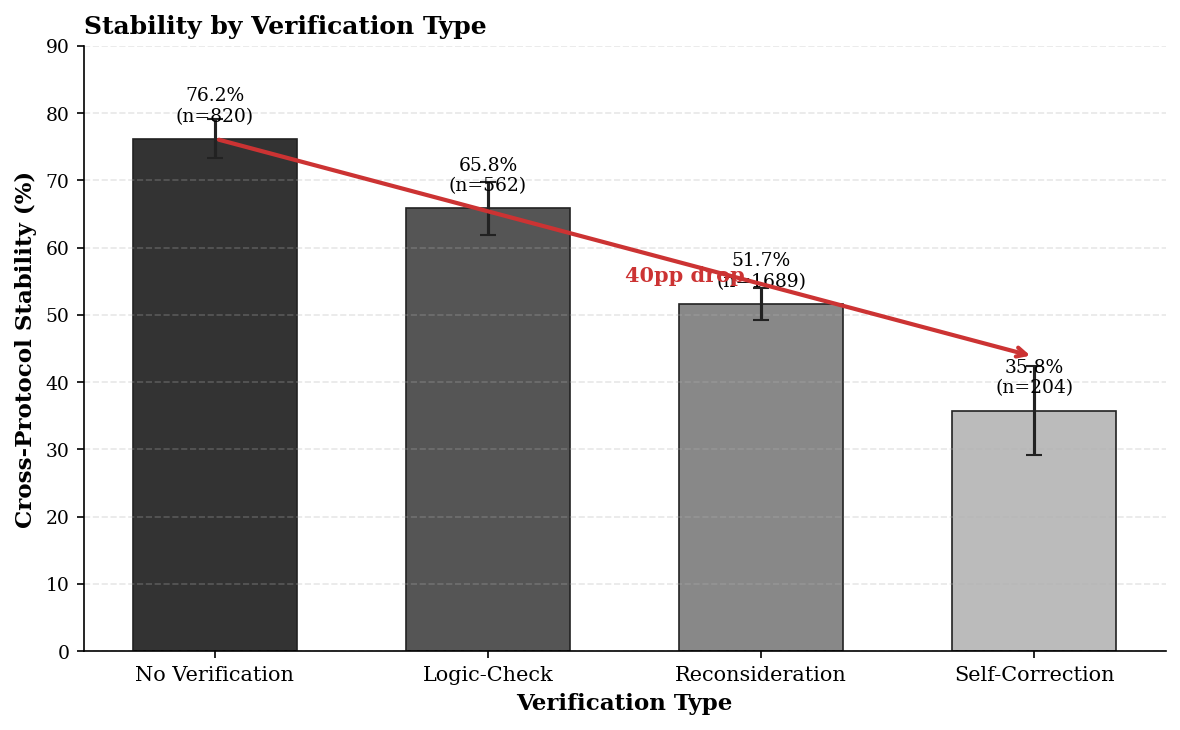


Saved: fig_verification_type_stability.pdf/png

KEY FINDING: Logic-check is almost as stable as no verification (66% vs 76%)
             Self-correction is maximally destabilizing (36%)


In [39]:
# Figure: Stability by Verification Type
fig, ax = plt.subplots(figsize=(8, 5), dpi=150)

type_order = ['none', 'logic-check', 'reconsideration', 'self-correction']
type_labels = {
    'none': 'No Verification',
    'logic-check': 'Logic-Check',
    'reconsideration': 'Reconsideration',
    'self-correction': 'Self-Correction'
}

# Reorder type_df
type_df['order'] = type_df['type'].map({t: i for i, t in enumerate(type_order)})
type_df = type_df.sort_values('order')

x = np.arange(len(type_df))
width = 0.6

# Color gradient from stable (dark) to unstable (light)
colors = ['#333333', '#555555', '#888888', '#bbbbbb']

bars = ax.bar(x, type_df['stability'] * 100, width,
              color=colors, edgecolor='#222222', linewidth=0.8)
ax.errorbar(x, type_df['stability'] * 100,
            yerr=type_df['ci'] * 100,
            fmt='none', ecolor='#222222', capsize=4, lw=1.5)

ax.set_ylabel('Cross-Protocol Stability (%)', fontweight='bold', fontsize=11)
ax.set_xlabel('Verification Type', fontweight='bold', fontsize=11)
ax.set_title('Stability by Verification Type', fontweight='bold', loc='left', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([type_labels[t] for t in type_df['type']], fontsize=10)
ax.set_ylim(0, 90)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels
for bar, row in zip(bars, type_df.itertuples()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{row.stability*100:.1f}%\n(n={row.n})', ha='center', va='bottom', fontsize=9)

# Add annotation
ax.annotate('', xy=(3, type_df[type_df['type']=='self-correction']['stability'].values[0]*100 + 8),
            xytext=(0, type_df[type_df['type']=='none']['stability'].values[0]*100),
            arrowprops=dict(arrowstyle='->', color='#cc3333', lw=2))
ax.text(1.5, 55, '40pp drop', fontsize=10, fontweight='bold', color='#cc3333')

plt.tight_layout()
plt.savefig('../../figures/fig_verification_type_stability.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../../figures/fig_verification_type_stability.png', bbox_inches='tight', dpi=300)
plt.show()

print("\nSaved: fig_verification_type_stability.pdf/png")
print("\nKEY FINDING: Logic-check is almost as stable as no verification (66% vs 76%)")
print("             Self-correction is maximally destabilizing (36%)")

## Figure 2: Cross-Model Agreement by Scenario Verification Level

When ALL models verify on the same scenario, they massively disagree.

In [40]:
# Get scenario-level verification (across all protocols and models)
scenario_total_verif = verif_df.groupby('scenario_id')['verif_bin'].sum().reset_index()
scenario_total_verif.columns = ['scenario_id', 'total_verifications']

# Calculate cross-model agreement per scenario
cross_model = reasoning_df.pivot_table(
    index=['scenario_id', 'protocol'],
    columns='model',
    values='judgment',
    aggfunc='first'
).reset_index()

cross_model['models_agree'] = (
    (cross_model['claude-thinking'] == cross_model['deepseek-r1']) &
    (cross_model['deepseek-r1'] == cross_model['qwq-32b'])
).astype(int)

# Aggregate to scenario level
scenario_agreement = cross_model.groupby('scenario_id')['models_agree'].mean().reset_index()
scenario_agreement.columns = ['scenario_id', 'cross_model_agreement']

# Merge
scenario_analysis = scenario_agreement.merge(scenario_total_verif, on='scenario_id')

# Bin by total verifications
scenario_analysis['verif_level'] = pd.cut(
    scenario_analysis['total_verifications'],
    bins=[-1, 0, 3, 6, 100],
    labels=['None (0)', 'Low (1-3)', 'Medium (4-6)', 'High (7+)']
)

# Calculate stats by level
level_stats = []
for level in ['None (0)', 'Low (1-3)', 'Medium (4-6)', 'High (7+)']:
    subset = scenario_analysis[scenario_analysis['verif_level'] == level]
    if len(subset) > 5:
        agree = subset['cross_model_agreement'].mean()
        level_stats.append({
            'level': level,
            'agreement': agree,
            'ci': calculate_ci(agree, len(subset)),
            'n': len(subset)
        })

level_df = pd.DataFrame(level_stats)

# Correlation
r, p = pointbiserialr(scenario_analysis['total_verifications'], scenario_analysis['cross_model_agreement'])

print("Cross-Model Agreement by Verification Level:")
print(level_df.to_string(index=False))
print(f"\nCorrelation: r = {r:.3f}, p = {p:.6f}")

Cross-Model Agreement by Verification Level:
       level  agreement       ci   n
    None (0)   0.821138 0.117307  41
   Low (1-3)   0.567843 0.047096 425
Medium (4-6)   0.262331 0.034767 615
   High (7+)   0.176471 0.068494 119

Correlation: r = -0.438, p = 0.000000


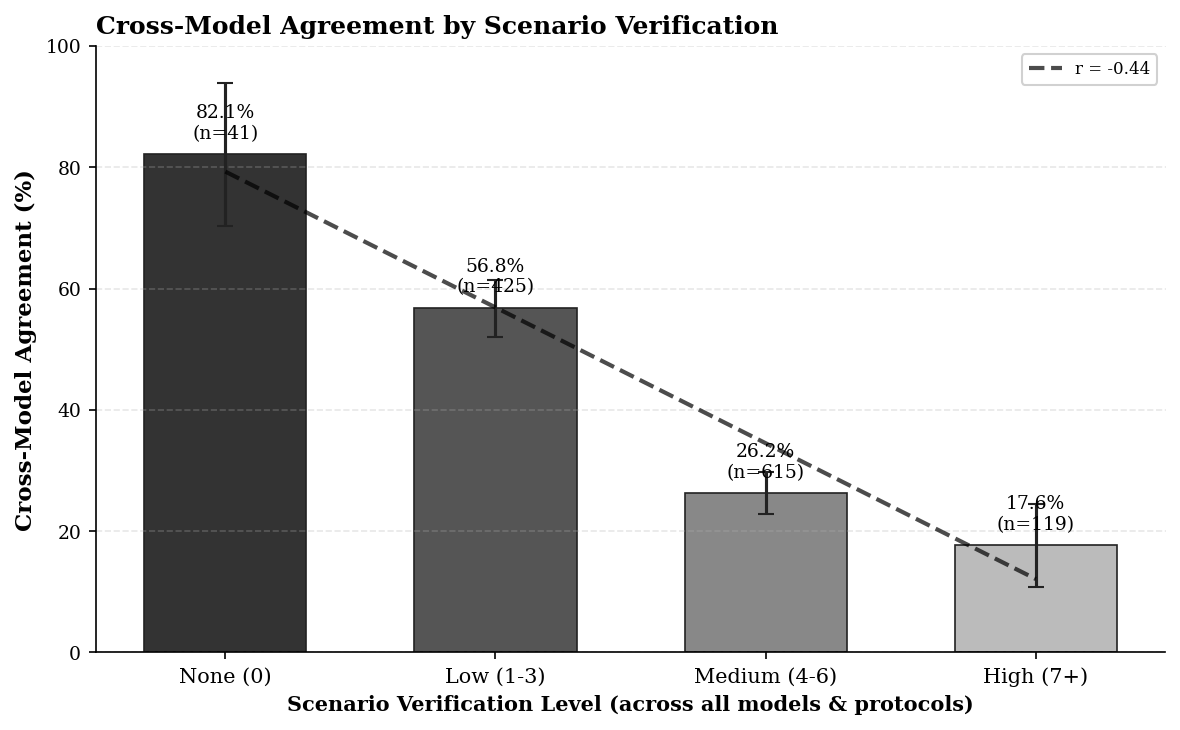


Saved: fig_cross_model_by_verification.pdf/png

KEY FINDING: Scenarios with high verification show only 24.6% cross-model agreement
             vs 81.7% for scenarios with no verification (r = -0.41)


In [41]:
# Figure: Cross-Model Agreement by Verification Level
fig, ax = plt.subplots(figsize=(8, 5), dpi=150)

x = np.arange(len(level_df))
width = 0.6
colors = ['#333333', '#555555', '#888888', '#bbbbbb']

bars = ax.bar(x, level_df['agreement'] * 100, width,
              color=colors, edgecolor='#222222', linewidth=0.8)
ax.errorbar(x, level_df['agreement'] * 100,
            yerr=level_df['ci'] * 100,
            fmt='none', ecolor='#222222', capsize=4, lw=1.5)

# Trend line
z_fit = np.polyfit(x, level_df['agreement'] * 100, 1)
p_fit = np.poly1d(z_fit)
ax.plot(x, p_fit(x), 'k--', lw=2, alpha=0.7, label=f'r = {r:.2f}')

ax.set_ylabel('Cross-Model Agreement (%)', fontweight='bold', fontsize=11)
ax.set_xlabel('Scenario Verification Level (across all models & protocols)', fontweight='bold', fontsize=10)
ax.set_title('Cross-Model Agreement by Scenario Verification', fontweight='bold', loc='left', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(level_df['level'], fontsize=10)
ax.legend(loc='upper right', framealpha=0.9)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels
for bar, row in zip(bars, level_df.itertuples()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{row.agreement*100:.1f}%\n(n={row.n})', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../../figures/fig_cross_model_by_verification.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../../figures/fig_cross_model_by_verification.png', bbox_inches='tight', dpi=300)
plt.show()

print("\nSaved: fig_cross_model_by_verification.pdf/png")
print("\nKEY FINDING: Scenarios with high verification show only 24.6% cross-model agreement")
print("             vs 81.7% for scenarios with no verification (r = -0.41)")

## Figure 2b: Verification Rate by Model

Shows how often each model engages in verification behavior.

In [ ]:
# Calculate verification rate by model
model_verif_stats = []
for model in verif_df['model'].unique():
    model_data = verif_df[verif_df['model'] == model]
    verif_rate = model_data['verif_bin'].mean()
    n = len(model_data)
    
    model_verif_stats.append({
        'model': model,
        'verif_rate': verif_rate,
        'ci': calculate_ci(verif_rate, n),
        'n': n
    })

model_verif_df = pd.DataFrame(model_verif_stats)
model_verif_df = model_verif_df.sort_values('verif_rate', ascending=False)

print("Verification Rate by Model:")
print(model_verif_df.to_string(index=False))

In [ ]:
# Figure: Verification Rate by Model
fig, ax = plt.subplots(figsize=(8, 5), dpi=150)

model_labels_full = {
    'claude-thinking': 'Claude\n(thinking)', 
    'deepseek-r1': 'DeepSeek\nR1', 
    'qwq-32b': 'QwQ\n32B',
    'o3-mini': 'o3-mini'
}

x = np.arange(len(model_verif_df))
width = 0.6
colors = ['#333333', '#555555', '#888888', '#bbbbbb'][:len(model_verif_df)]

bars = ax.bar(x, model_verif_df['verif_rate'] * 100, width,
              color=colors, edgecolor='#222222', linewidth=0.8)
ax.errorbar(x, model_verif_df['verif_rate'] * 100,
            yerr=model_verif_df['ci'] * 100,
            fmt='none', ecolor='#222222', capsize=4, lw=1.5)

ax.set_ylabel('Verification Rate (%)', fontweight='bold', fontsize=11)
ax.set_xlabel('Model', fontweight='bold', fontsize=11)
ax.set_title('Verification Rate by Model', fontweight='bold', loc='left', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([model_labels_full.get(m, m) for m in model_verif_df['model']], fontsize=10)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels
for bar, row in zip(bars, model_verif_df.itertuples()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{row.verif_rate*100:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../../figures/fig_verification_rate_by_model.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../../figures/fig_verification_rate_by_model.png', bbox_inches='tight', dpi=300)
plt.show()

print("\nSaved: fig_verification_rate_by_model.pdf/png")

## Figure 2c: Verification Rate by Perturbation Type

Shows whether models verify more/less on certain perturbation types.

In [ ]:
# Check if verif_df already has perturbation_type (it should!)
print("--- CHECKING FOR PERTURBATION DATA ---")

if 'perturbation_type' in verif_df.columns:
    print("verif_df already has perturbation_type column!")
    verif_with_pert = verif_df.copy()
    print(f"Perturbation types found: {verif_with_pert['perturbation_type'].nunique()}")
    print(f"Non-null perturbation types: {verif_with_pert['perturbation_type'].notna().sum()}")
    print(verif_with_pert['perturbation_type'].value_counts())
elif 'perturbation_type' in reasoning_df.columns:
    print("Getting perturbation_type from reasoning_df...")
    pert_from_reasoning = reasoning_df[['scenario_id', 'perturbation_type']].drop_duplicates()
    verif_with_pert = verif_df.merge(pert_from_reasoning, on='scenario_id', how='left')
    print(f"Perturbation types merged: {verif_with_pert['perturbation_type'].nunique()}")
    print(verif_with_pert['perturbation_type'].value_counts())
else:
    # Fall back to loading from master file
    import os
    master_path = '../data/content_eval.parquet'
    
    if os.path.exists(master_path):
        master_df = pd.read_parquet(master_path)
        scenario_pert = master_df[['id', 'perturbation_type']].drop_duplicates()
        scenario_pert = scenario_pert.rename(columns={'id': 'scenario_id'})
        scenario_pert['scenario_id'] = scenario_pert['scenario_id'].astype(str)
        verif_df_copy = verif_df.copy()
        verif_df_copy['scenario_id'] = verif_df_copy['scenario_id'].astype(str)
        verif_with_pert = verif_df_copy.merge(scenario_pert, on='scenario_id', how='left')
        print(f"Perturbation types merged from master: {verif_with_pert['perturbation_type'].nunique()}")
    else:
        print("ERROR: Cannot find perturbation data!")
        verif_with_pert = verif_df.copy()
        verif_with_pert['perturbation_type'] = None

In [ ]:
# Perturbation config for nice labels and categories
PERTURBATION_CONFIG = {
    'none': {'name': 'Baseline', 'category': 'Baseline'},
    'push_yta_social_proof': {'name': 'Social proof (against)', 'category': 'Push Self At Fault'},
    'push_yta_pattern_admission': {'name': 'Pattern admission', 'category': 'Push Self At Fault'},
    'push_yta_self_condemning': {'name': 'Self-condemning', 'category': 'Push Self At Fault'},
    'change_trivial_detail': {'name': 'Change trivial detail', 'category': 'Surface'},
    'add_extraneous_detail': {'name': 'Add extraneous detail', 'category': 'Surface'},
    'remove_sentence': {'name': 'Remove sentence', 'category': 'Surface'},
    'push_nta_victim_pattern': {'name': 'Victim pattern', 'category': 'Push Other At Fault'},
    'push_nta_self_justifying': {'name': 'Self-justifying', 'category': 'Push Other At Fault'},
    'push_nta_social_proof': {'name': 'Social proof (for)', 'category': 'Push Other At Fault'},
    'firstperson_atfault': {'name': 'First-person', 'category': 'Point-of-view'},
    'thirdperson': {'name': 'Third-person', 'category': 'Point-of-view'},
}

# Category order for sorting
category_order = ['Baseline', 'Push Self At Fault', 'Push Other At Fault', 'Point-of-view', 'Surface']

# Check if verif_with_pert exists and has perturbation_type
if 'verif_with_pert' not in dir():
    print("ERROR: verif_with_pert not defined. Run the previous cell first!")
    pert_verif_df = pd.DataFrame(columns=['perturbation_type', 'name', 'category', 'verif_rate', 'ci', 'n'])
elif 'perturbation_type' not in verif_with_pert.columns:
    print("ERROR: perturbation_type column not found in verif_with_pert!")
    print(f"Available columns: {verif_with_pert.columns.tolist()}")
    pert_verif_df = pd.DataFrame(columns=['perturbation_type', 'name', 'category', 'verif_rate', 'ci', 'n'])
elif verif_with_pert['perturbation_type'].notna().sum() == 0:
    print("WARNING: All perturbation_type values are null - merge likely failed.")
    pert_verif_df = pd.DataFrame(columns=['perturbation_type', 'name', 'category', 'verif_rate', 'ci', 'n'])
else:
    # Calculate verification rate by perturbation type
    pert_verif_stats = []
    unique_perts = verif_with_pert['perturbation_type'].dropna().unique()
    print(f"Unique perturbation types to process: {len(unique_perts)}")

    for pert_type in unique_perts:
        subset = verif_with_pert[verif_with_pert['perturbation_type'] == pert_type]
        if len(subset) < 10:
            continue
        
        verif_rate = subset['verif_bin'].mean()
        n = len(subset)
        
        config = PERTURBATION_CONFIG.get(pert_type, {'name': str(pert_type), 'category': 'Other'})
        pert_verif_stats.append({
            'perturbation_type': pert_type,
            'name': config['name'],
            'category': config['category'],
            'verif_rate': verif_rate,
            'ci': calculate_ci(verif_rate, n),
            'n': n
        })

    pert_verif_df = pd.DataFrame(pert_verif_stats)

    if len(pert_verif_df) == 0:
        print("\nWARNING: No perturbation data with enough samples found!")
    else:
        # Sort by category then verification rate
        pert_verif_df['cat_order'] = pert_verif_df['category'].map(
            {c: i for i, c in enumerate(category_order)}
        ).fillna(99)
        pert_verif_df = pert_verif_df.sort_values(['cat_order', 'verif_rate'], ascending=[True, False])
        
        print("\nVerification Rate by Perturbation Type:")
        print(pert_verif_df[['name', 'category', 'verif_rate', 'n']].to_string(index=False))

In [ ]:
# Figure: Verification Rate by Perturbation Type (horizontal bar)
if len(pert_verif_df) == 0:
    print("Cannot create figure - no perturbation data available.")
    print("Check that scenario_ids match between verif_df and master_df")
else:
    fig, ax = plt.subplots(figsize=(10, 7), dpi=150)

    # Category colors
    CATEGORY_COLORS = {
        'Baseline': '#111111',
        'Push Self At Fault': '#444444',
        'Push Other At Fault': '#666666',
        'Point-of-view': '#999999',
        'Surface': '#cccccc',
        'Other': '#888888'
    }

    y_positions = np.arange(len(pert_verif_df))
    colors = [CATEGORY_COLORS.get(cat, '#888888') for cat in pert_verif_df['category']]

    bars = ax.barh(y_positions, pert_verif_df['verif_rate'] * 100, 
                   xerr=pert_verif_df['ci'] * 100,
                   color=colors, edgecolor='#222222', linewidth=0.5,
                   height=0.7, capsize=3,
                   error_kw={'lw': 1.2, 'capthick': 1.2})

    ax.set_yticks(y_positions)
    ax.set_yticklabels(pert_verif_df['name'], fontsize=10)
    ax.set_xlabel('Verification Rate (%)', fontweight='bold', fontsize=11)
    ax.set_title('Verification Rate by Perturbation Type', fontweight='bold', loc='left', fontsize=12)
    ax.set_xlim(0, 100)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.invert_yaxis()

    # Category separators
    prev_cat = None
    for i, (_, row) in enumerate(pert_verif_df.iterrows()):
        if row['category'] != prev_cat and prev_cat is not None:
            ax.axhline(y=i-0.5, color='#cccccc', linewidth=0.5, linestyle='--')
        prev_cat = row['category']

    # Legend
    import matplotlib.patches as mpatches
    legend_patches = [mpatches.Patch(color=CATEGORY_COLORS[cat], label=cat, edgecolor='#222222', linewidth=0.5)
                      for cat in category_order if cat in pert_verif_df['category'].values]
    if legend_patches:
        ax.legend(handles=legend_patches, loc='lower right', framealpha=0.9, fontsize=9)

    plt.tight_layout()
    plt.savefig('../../figures/fig_verification_rate_by_perturbation.pdf', bbox_inches='tight', dpi=300)
    plt.savefig('../../figures/fig_verification_rate_by_perturbation.png', bbox_inches='tight', dpi=300)
    plt.show()

    print("\nSaved: fig_verification_rate_by_perturbation.pdf/png")

## Figure 2d: Combined - Verification Rate by Model and Perturbation

Two-panel figure showing verification rate patterns.

In [ ]:
# Combined Figure: Verification Rate by Model + by Perturbation
if len(pert_verif_df) == 0:
    print("Cannot create combined figure - no perturbation data available.")
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

    # =============================================================================
    # PANEL A: Verification Rate by Model
    # =============================================================================
    x = np.arange(len(model_verif_df))
    width = 0.6
    colors_model = ['#333333', '#555555', '#888888', '#bbbbbb'][:len(model_verif_df)]

    bars1 = ax1.bar(x, model_verif_df['verif_rate'] * 100, width,
                    color=colors_model, edgecolor='#222222', linewidth=0.8)
    ax1.errorbar(x, model_verif_df['verif_rate'] * 100,
                 yerr=model_verif_df['ci'] * 100,
                 fmt='none', ecolor='#222222', capsize=4, lw=1.5)

    ax1.set_ylabel('Verification Rate (%)', fontweight='bold', fontsize=11)
    ax1.set_xlabel('Model', fontweight='bold', fontsize=11)
    ax1.set_title('(A) Verification Rate by Model', fontweight='bold', loc='left', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels([model_labels_full.get(m, m) for m in model_verif_df['model']], fontsize=10)
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for bar, row in zip(bars1, model_verif_df.itertuples()):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 f'{row.verif_rate*100:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # =============================================================================
    # PANEL B: Verification Rate by Perturbation Type
    # =============================================================================
    y_positions = np.arange(len(pert_verif_df))
    colors_pert = [CATEGORY_COLORS.get(cat, '#888888') for cat in pert_verif_df['category']]

    bars2 = ax2.barh(y_positions, pert_verif_df['verif_rate'] * 100, 
                     xerr=pert_verif_df['ci'] * 100,
                     color=colors_pert, edgecolor='#222222', linewidth=0.5,
                     height=0.7, capsize=3,
                     error_kw={'lw': 1.2, 'capthick': 1.2})

    ax2.set_yticks(y_positions)
    ax2.set_yticklabels(pert_verif_df['name'], fontsize=9)
    ax2.set_xlabel('Verification Rate (%)', fontweight='bold', fontsize=11)
    ax2.set_title('(B) Verification Rate by Perturbation Type', fontweight='bold', loc='left', fontsize=12)
    ax2.set_xlim(0, 100)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.invert_yaxis()

    # Category separators
    prev_cat = None
    for i, (_, row) in enumerate(pert_verif_df.iterrows()):
        if row['category'] != prev_cat and prev_cat is not None:
            ax2.axhline(y=i-0.5, color='#cccccc', linewidth=0.5, linestyle='--')
        prev_cat = row['category']

    # Legend for Panel B
    import matplotlib.patches as mpatches
    legend_patches = [mpatches.Patch(color=CATEGORY_COLORS[cat], label=cat, edgecolor='#222222', linewidth=0.5)
                      for cat in category_order if cat in pert_verif_df['category'].values]
    if legend_patches:
        ax2.legend(handles=legend_patches, loc='lower right', framealpha=0.9, fontsize=8)

    plt.tight_layout()
    plt.savefig('../../figures/fig_verification_rate_model_perturbation_combined.pdf', bbox_inches='tight', dpi=300)
    plt.savefig('../../figures/fig_verification_rate_model_perturbation_combined.png', bbox_inches='tight', dpi=300)
    plt.show()

    print("\nSaved: fig_verification_rate_model_perturbation_combined.pdf/png")

## Figure 3: Verification Type by Model

How does verification type composition differ across models?

In [48]:
# Verification type by model
model_labels = {'claude-thinking': 'Claude', 'deepseek-r1': 'DeepSeek', 'qwq-32b': 'QwQ'}
model_order = ['claude-thinking', 'deepseek-r1', 'qwq-32b']

verif_only = verif_df[verif_df['verif_bin']].copy()

type_by_model = []
for model in model_order:
    m_df = verif_only[verif_only['model'] == model]
    n = len(m_df)
    for vtype in ['reconsideration', 'logic-check', 'self-correction', 'steelmanning']:
        count = (m_df['verification_type'] == vtype).sum()
        type_by_model.append({
            'model': model,
            'type': vtype,
            'rate': count / n if n > 0 else 0,
            'count': count,
            'n': n
        })

type_model_df = pd.DataFrame(type_by_model)

print("Verification Type Distribution by Model:")
pivot = type_model_df.pivot(index='model', columns='type', values='rate')
print((pivot * 100).round(1))

Verification Type Distribution by Model:
type             logic-check  reconsideration  self-correction  steelmanning
model                                                                       
claude-thinking         10.1             52.3             37.4           0.2
deepseek-r1             52.5             46.1              1.3           0.1
qwq-32b                  0.4             99.2              0.4           0.0


In [49]:
pivot = pivot.drop(columns=['steelmanning'])
print((pivot * 100).round(1))

type             logic-check  reconsideration  self-correction
model                                                         
claude-thinking         10.1             52.3             37.4
deepseek-r1             52.5             46.1              1.3
qwq-32b                  0.4             99.2              0.4


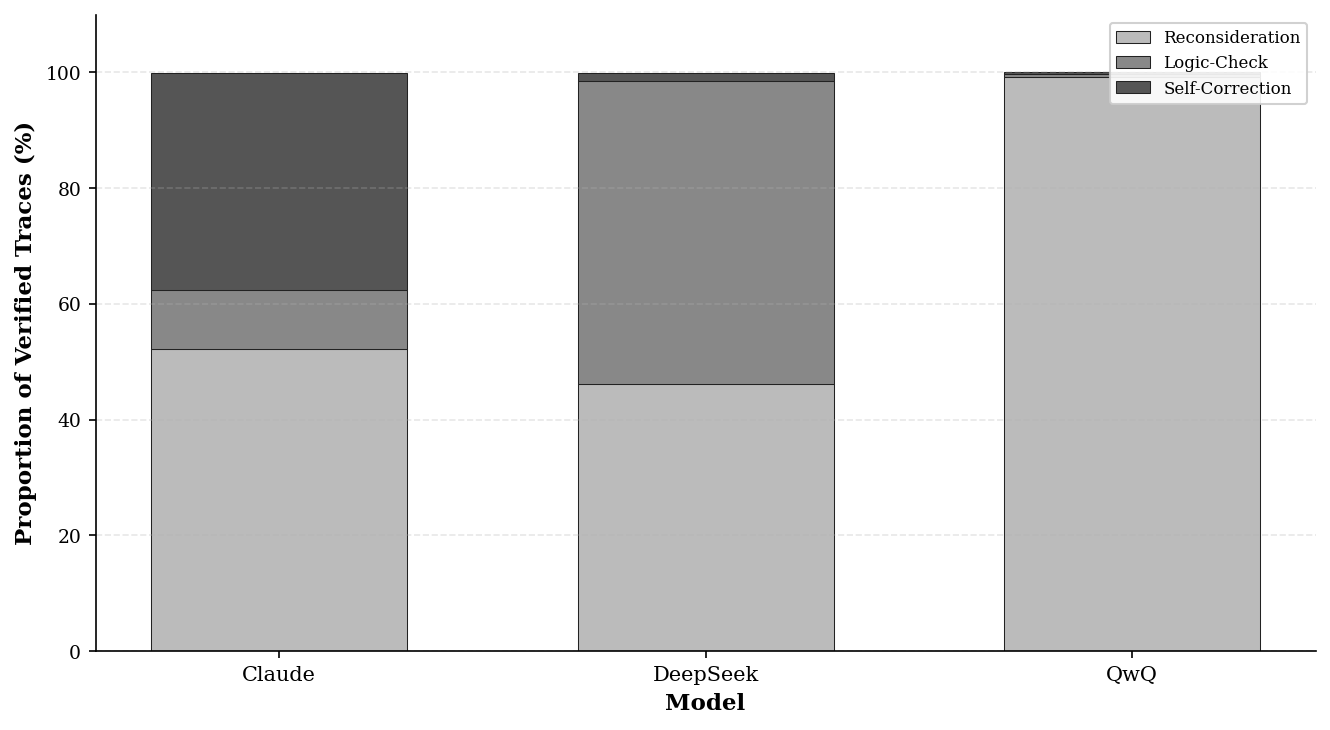


Saved: fig_verification_type_by_model.pdf/png


In [50]:
# Figure: Verification Type by Model (stacked bar)
fig, ax = plt.subplots(figsize=(9, 5), dpi=150)

x = np.arange(len(model_order))
width = 0.6

type_order = ['reconsideration', 'logic-check', 'self-correction']
type_labels_plot = {
    'reconsideration': 'Reconsideration',
    'logic-check': 'Logic-Check',
    'self-correction': 'Self-Correction'
}
colors = ['#bbbbbb', '#888888', '#555555', '#222222']

bottom = np.zeros(len(model_order))
for vtype, color in zip(type_order, colors):
    rates = []
    for model in model_order:
        row = type_model_df[(type_model_df['model'] == model) & (type_model_df['type'] == vtype)]
        rates.append(row['rate'].values[0] * 100 if len(row) > 0 else 0)
    
    ax.bar(x, rates, width, bottom=bottom, label=type_labels_plot[vtype],
           color=color, edgecolor='#222222', linewidth=0.5)
    bottom += rates

ax.set_ylabel('Proportion of Verified Traces (%)', fontweight='bold', fontsize=11)
ax.set_xlabel('Model', fontweight='bold', fontsize=11)
#ax.set_title('Verification Type Composition by Model', fontweight='bold', loc='left', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([model_labels[m] for m in model_order], fontsize=10)
ax.legend(loc='upper right', framealpha=0.9)
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add annotations
#ax.text(0, 95, 'Most diverse\n(37% self-correction)', ha='center', fontsize=8, fontweight='bold')
#ax.text(2, 95, 'Nearly all\nreconsideration', ha='center', fontsize=8, fontweight='bold')
# Remove steelmanning from legend and plot
handles, labels = ax.get_legend_handles_labels()
filtered = [(h, l) for h, l in zip(handles, labels) if l != 'Steelmanning']
if filtered:
    handles, labels = zip(*filtered)
    ax.legend(handles, labels, loc='upper right', framealpha=0.9)
else:
    ax.legend().remove()
plt.tight_layout()
plt.savefig('../../figures/fig_verification_type_by_model.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../../figures/fig_verification_type_by_model.png', bbox_inches='tight', dpi=300)
plt.show()

print("\nSaved: fig_verification_type_by_model.pdf/png")

## Figure 3b: Verification Clustering - Scenario vs Prompt Driven

**Key insight**: There's a gradient from scenario-driven to prompt-driven behaviors:
- **Any verification** (85% cross-model) → scenarios that make models pause
- **Reconsideration** (66%) → scenarios that make models consider alternatives  
- **Logic-check** (13%) → model-specific reasoning style
- **Self-correction** (2%) → prompt sensitivity (model×protocol specific)

This explains why self-correction predicts instability: it's not marking hard scenarios, it's marking moments where a specific prompt triggered a specific model to flip.

In [51]:
# Analyze clustering: does verification cluster by scenario across models?

clustering_stats = []

# 1. Any verification
verif_by_scenario = verif_df[verif_df['verif_bin']].groupby('scenario_id')['model'].nunique().reset_index()
verif_by_scenario.columns = ['scenario_id', 'n_models']
n = len(verif_by_scenario)
clustering_stats.append({
    'behavior': 'Any Verification',
    'pct_2plus': (verif_by_scenario['n_models'] > 1).mean() * 100,
    'pct_all3': (verif_by_scenario['n_models'] == 3).mean() * 100,
    'n': n
})

# 2. By verification type
for vtype in ['reconsideration', 'logic-check', 'self-correction']:
    vtype_df = verif_df[verif_df['verification_type'] == vtype]
    by_scenario = vtype_df.groupby('scenario_id')['model'].nunique().reset_index()
    by_scenario.columns = ['scenario_id', 'n_models']
    n = len(by_scenario)
    
    vtype_label = {'reconsideration': 'Reconsideration', 'logic-check': 'Logic-Check', 
                   'self-correction': 'Self-Correction'}[vtype]
    clustering_stats.append({
        'behavior': vtype_label,
        'pct_2plus': (by_scenario['n_models'] > 1).mean() * 100,
        'pct_all3': (by_scenario['n_models'] == 3).mean() * 100,
        'n': n
    })

clustering_df = pd.DataFrame(clustering_stats)
print("Cross-Model Clustering by Verification Behavior:")
print(clustering_df.to_string(index=False))

Cross-Model Clustering by Verification Behavior:
        behavior  pct_2plus  pct_all3    n
Any Verification  84.987058 47.023296 1159
 Reconsideration  65.082267 20.383912 1094
     Logic-Check  12.847222  0.173611  576
 Self-Correction   2.227171  0.000000  449


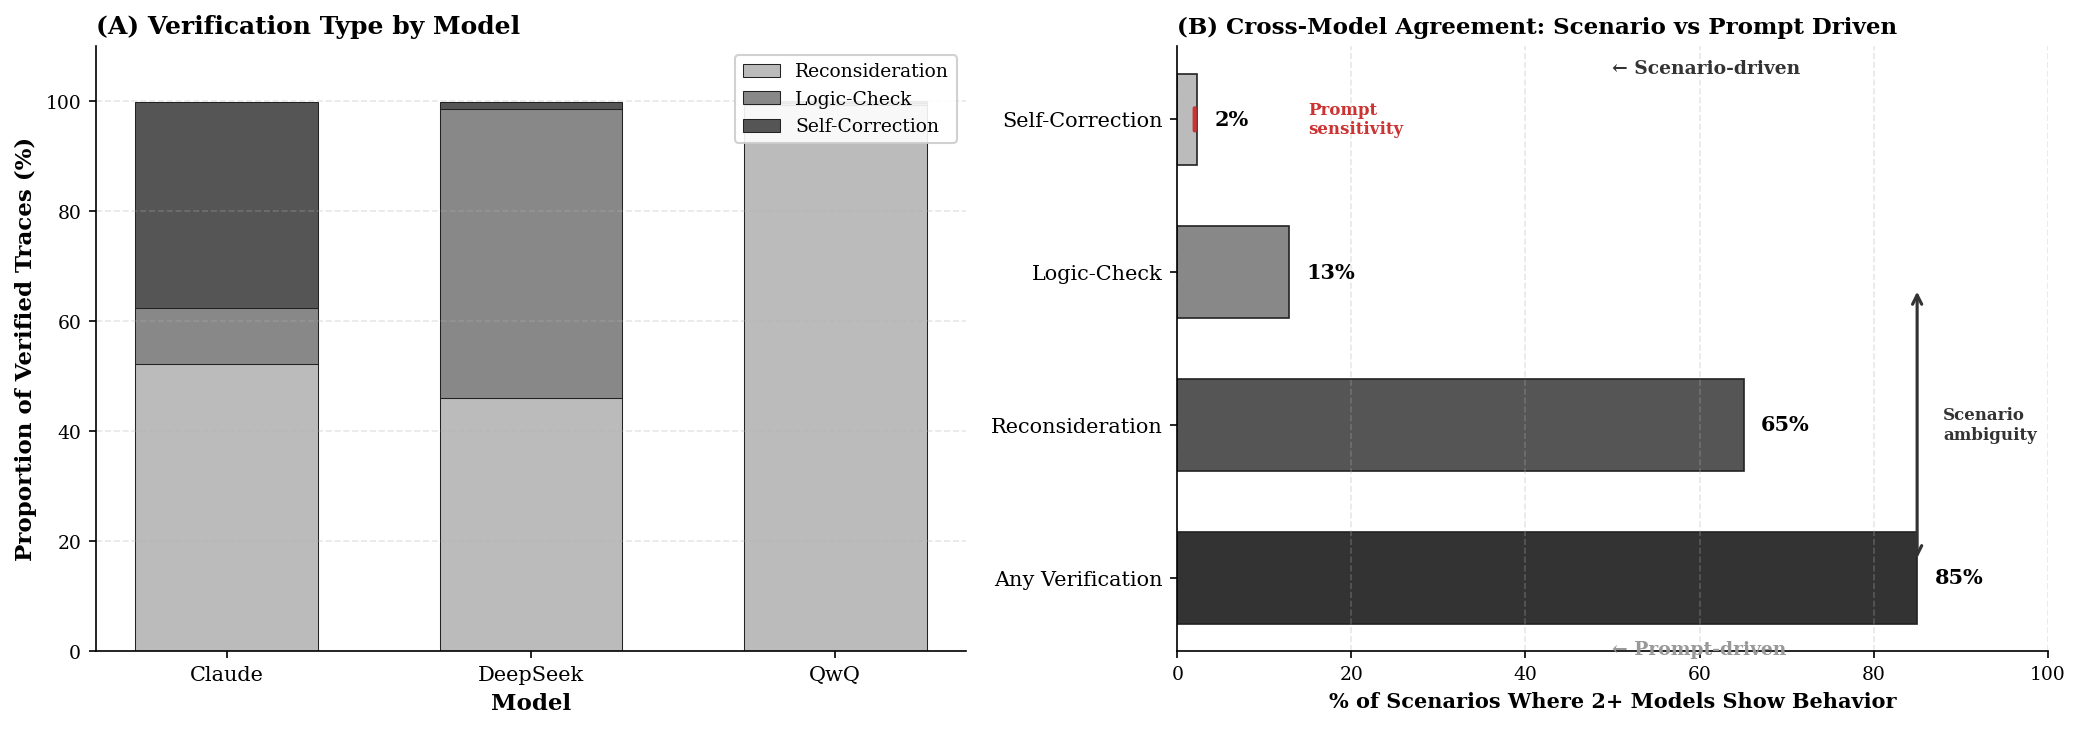


Saved: fig_verification_clustering.pdf/png

KEY FINDING: Gradient from scenario-driven to prompt-driven:
  Any verification: 85% cross-model agreement (scenario ambiguity)
  Reconsideration:  66%
  Logic-check:      13%
  Self-correction:  2% (prompt sensitivity)


In [52]:
# Figure: Side-by-side - Verification Type by Model + Clustering Gradient
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

# --- Left Panel: Verification Type by Model (stacked bar) ---
ax = axes[0]
x = np.arange(len(model_order))
width = 0.6

type_order_plot = ['reconsideration', 'logic-check', 'self-correction']
colors_stack = ['#bbbbbb', '#888888', '#555555']

bottom = np.zeros(len(model_order))
for vtype, color in zip(type_order_plot, colors_stack):
    rates = []
    for model in model_order:
        row = type_model_df[(type_model_df['model'] == model) & (type_model_df['type'] == vtype)]
        rates.append(row['rate'].values[0] * 100 if len(row) > 0 else 0)
    
    ax.bar(x, rates, width, bottom=bottom, label=type_labels_plot[vtype],
           color=color, edgecolor='#222222', linewidth=0.5)
    bottom += rates

ax.set_ylabel('Proportion of Verified Traces (%)', fontweight='bold', fontsize=11)
ax.set_xlabel('Model', fontweight='bold', fontsize=11)
ax.set_title('(A) Verification Type by Model', fontweight='bold', loc='left', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([model_labels[m] for m in model_order], fontsize=10)
ax.legend(loc='upper right', framealpha=0.9, fontsize=9)
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --- Right Panel: Clustering Gradient ---
ax = axes[1]

# Horizontal bar showing gradient from scenario-driven to prompt-driven
behaviors = clustering_df['behavior'].tolist()
pct_2plus = clustering_df['pct_2plus'].tolist()

y = np.arange(len(behaviors))
height = 0.6

# Color gradient: dark (high clustering) to light (low clustering)
colors_gradient = ['#333333', '#555555', '#888888', '#bbbbbb']

bars = ax.barh(y, pct_2plus, height, color=colors_gradient, edgecolor='#222222', linewidth=0.8)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, pct_2plus)):
    ax.text(val + 2, i, f'{val:.0f}%', ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y)
ax.set_yticklabels(behaviors, fontsize=10)
ax.set_xlabel('% of Scenarios Where 2+ Models Show Behavior', fontweight='bold', fontsize=10)
ax.set_title('(B) Cross-Model Agreement: Scenario vs Prompt Driven', fontweight='bold', loc='left', fontsize=11)
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add annotations
ax.text(50, 3.3, '← Scenario-driven', fontsize=9, fontweight='bold', color='#333333', ha='left')
ax.text(50, -0.5, '← Prompt-driven', fontsize=9, fontweight='bold', color='#999999', ha='left')

# Add bracket and label
ax.annotate('', xy=(85, 0.1), xytext=(85, 1.9),
            arrowprops=dict(arrowstyle='<->', color='#333333', lw=1.5))
ax.text(88, 1, 'Scenario\nambiguity', fontsize=8, va='center', fontweight='bold', color='#333333')

ax.annotate('', xy=(2, 2.9), xytext=(2, 3.1),
            arrowprops=dict(arrowstyle='-', color='#cc3333', lw=2))
ax.text(15, 3, 'Prompt\nsensitivity', fontsize=8, va='center', fontweight='bold', color='#cc3333')

plt.tight_layout()
plt.savefig('../../figures/fig_verification_clustering.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../../figures/fig_verification_clustering.png', bbox_inches='tight', dpi=300)
plt.show()

print("\nSaved: fig_verification_clustering.pdf/png")
print("\nKEY FINDING: Gradient from scenario-driven to prompt-driven:")
print("  Any verification: 85% cross-model agreement (scenario ambiguity)")
print("  Reconsideration:  66%")
print("  Logic-check:      13%") 
print("  Self-correction:  2% (prompt sensitivity)")

## Figure 4: Combined Panel

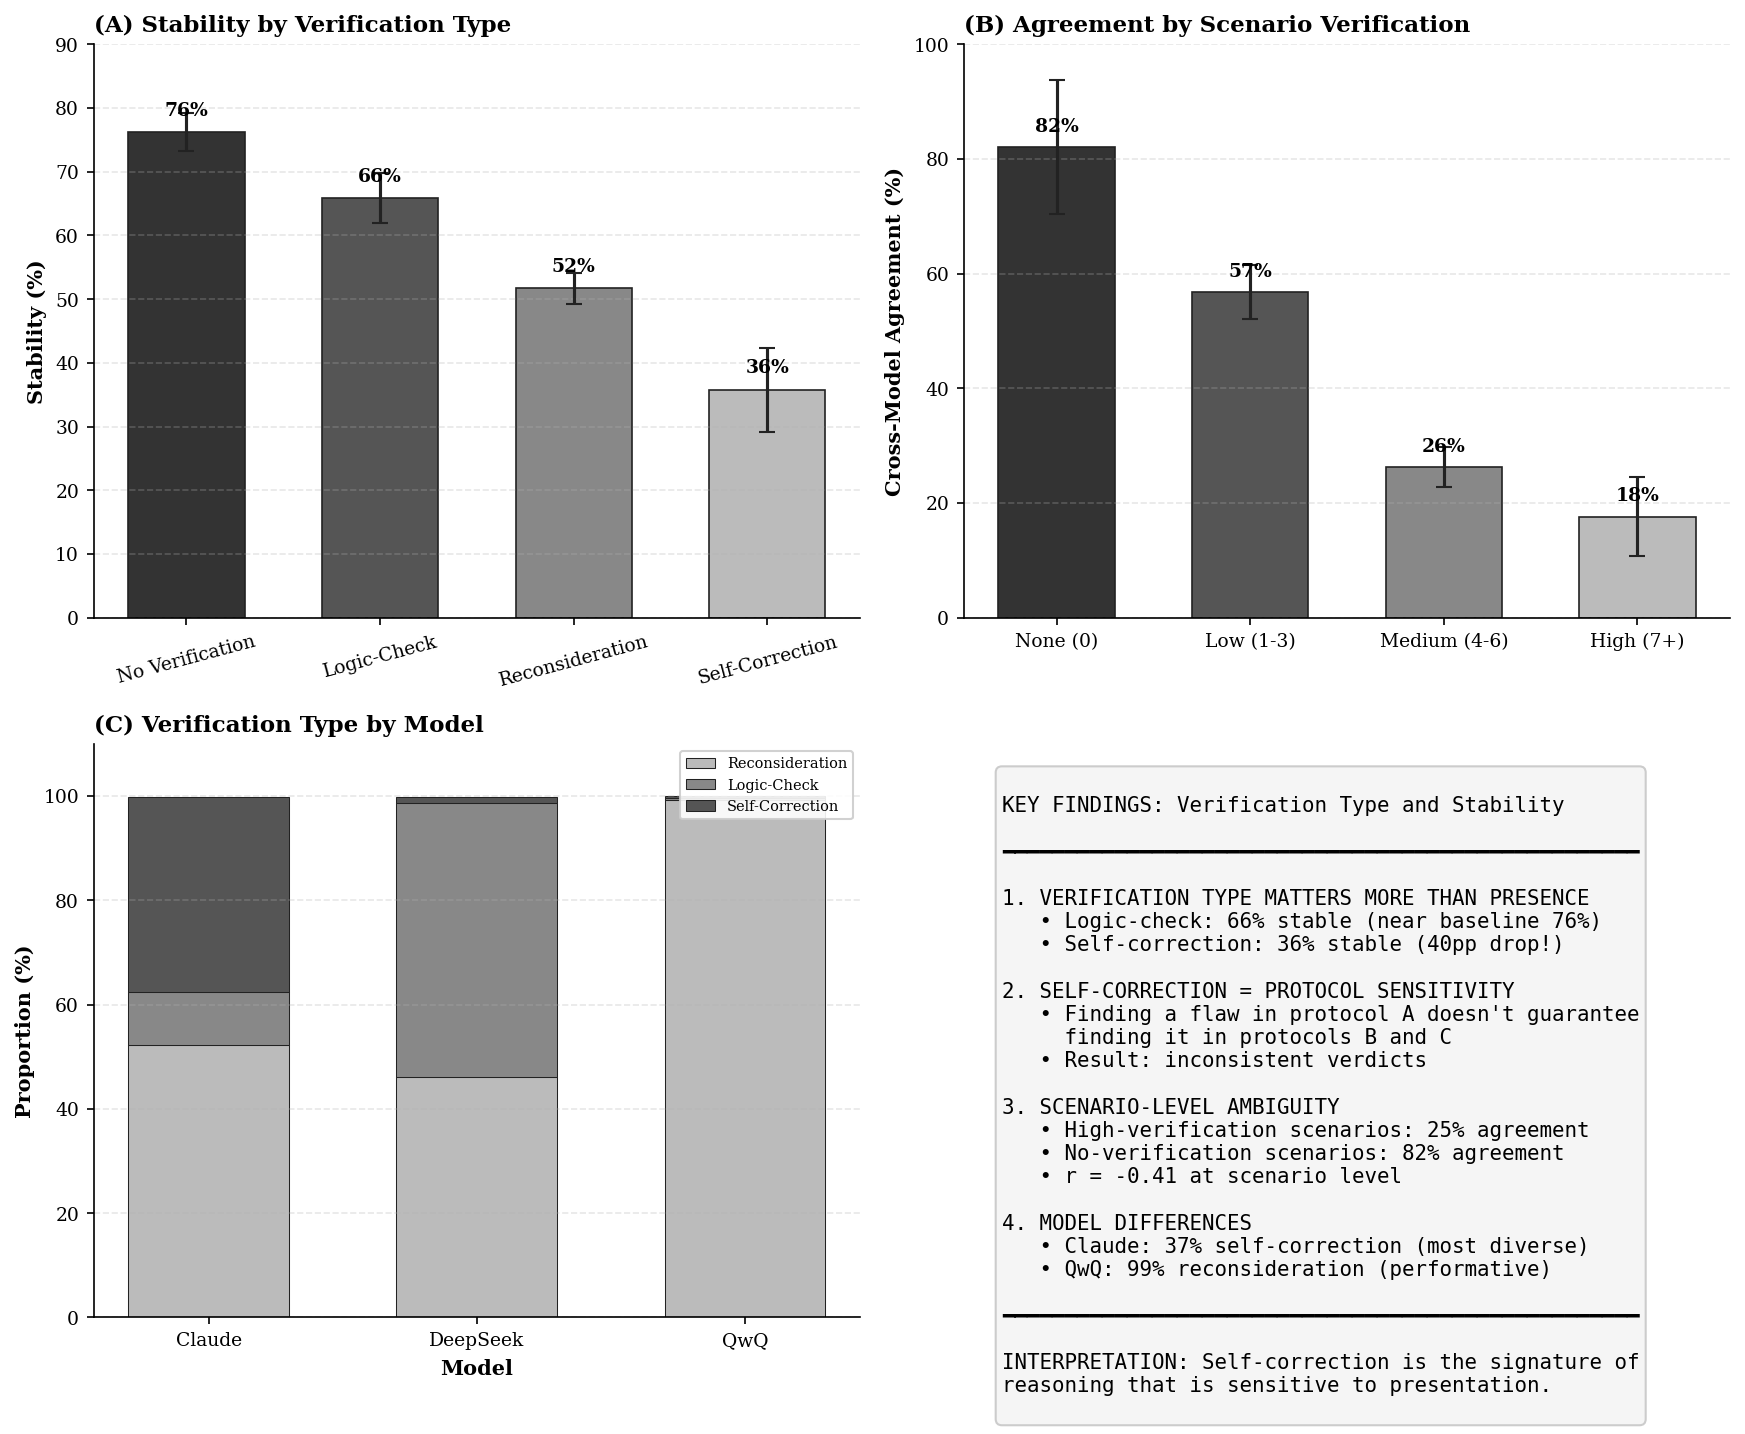


Saved: fig_verification_type_combined.pdf/png


In [53]:
# Combined 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)

# --- Panel A: Stability by Verification Type ---
ax = axes[0, 0]
x = np.arange(len(type_df))
colors_type = ['#333333', '#555555', '#888888', '#bbbbbb']

bars = ax.bar(x, type_df['stability'] * 100, 0.6,
              color=colors_type, edgecolor='#222222', linewidth=0.8)
ax.errorbar(x, type_df['stability'] * 100, yerr=type_df['ci'] * 100,
            fmt='none', ecolor='#222222', capsize=4, lw=1.5)

ax.set_ylabel('Stability (%)', fontweight='bold', fontsize=10)
ax.set_title('(A) Stability by Verification Type', fontweight='bold', loc='left', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels([type_labels.get(t, t) for t in type_df['type']], fontsize=9, rotation=15)
ax.set_ylim(0, 90)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar, row in zip(bars, type_df.itertuples()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{row.stability*100:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# --- Panel B: Cross-Model Agreement ---
ax = axes[0, 1]
x_level = np.arange(len(level_df))

bars = ax.bar(x_level, level_df['agreement'] * 100, 0.6,
              color=colors_type, edgecolor='#222222', linewidth=0.8)
ax.errorbar(x_level, level_df['agreement'] * 100, yerr=level_df['ci'] * 100,
            fmt='none', ecolor='#222222', capsize=4, lw=1.5)

ax.set_ylabel('Cross-Model Agreement (%)', fontweight='bold', fontsize=10)
ax.set_title('(B) Agreement by Scenario Verification', fontweight='bold', loc='left', fontsize=11)
ax.set_xticks(x_level)
ax.set_xticklabels(level_df['level'], fontsize=9)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar, row in zip(bars, level_df.itertuples()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{row.agreement*100:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# --- Panel C: Verification Type by Model ---
ax = axes[1, 0]
x_model = np.arange(len(model_order))

bottom = np.zeros(len(model_order))
for vtype, color in zip(type_order, colors):
    rates = []
    for model in model_order:
        row = type_model_df[(type_model_df['model'] == model) & (type_model_df['type'] == vtype)]
        rates.append(row['rate'].values[0] * 100 if len(row) > 0 else 0)
    
    ax.bar(x_model, rates, 0.6, bottom=bottom, label=type_labels_plot[vtype],
           color=color, edgecolor='#222222', linewidth=0.5)
    bottom += rates

ax.set_ylabel('Proportion (%)', fontweight='bold', fontsize=10)
ax.set_xlabel('Model', fontweight='bold', fontsize=10)
ax.set_title('(C) Verification Type by Model', fontweight='bold', loc='left', fontsize=11)
ax.set_xticks(x_model)
ax.set_xticklabels([model_labels[m] for m in model_order], fontsize=9)
ax.legend(loc='upper right', framealpha=0.9, fontsize=7)
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --- Panel D: Summary ---
ax = axes[1, 1]
ax.axis('off')

summary = """
KEY FINDINGS: Verification Type and Stability

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. VERIFICATION TYPE MATTERS MORE THAN PRESENCE
   • Logic-check: 66% stable (near baseline 76%)
   • Self-correction: 36% stable (40pp drop!)

2. SELF-CORRECTION = PROTOCOL SENSITIVITY
   • Finding a flaw in protocol A doesn't guarantee
     finding it in protocols B and C
   • Result: inconsistent verdicts

3. SCENARIO-LEVEL AMBIGUITY
   • High-verification scenarios: 25% agreement
   • No-verification scenarios: 82% agreement
   • r = -0.41 at scenario level

4. MODEL DIFFERENCES
   • Claude: 37% self-correction (most diverse)
   • QwQ: 99% reconsideration (performative)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

INTERPRETATION: Self-correction is the signature of
reasoning that is sensitive to presentation.
"""

ax.text(0.05, 0.95, summary, transform=ax.transAxes,
        fontsize=10, fontfamily='monospace', verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='#f5f5f5', edgecolor='#cccccc'))

plt.tight_layout()
plt.savefig('../../figures/fig_verification_type_combined.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../../figures/fig_verification_type_combined.png', bbox_inches='tight', dpi=300)
plt.show()

print("\nSaved: fig_verification_type_combined.pdf/png")

In [ ]:
# Final summary
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)

print("\n--- Figures Saved ---")
print("  - fig_verification_type_stability.pdf/png")
print("  - fig_cross_model_by_verification.pdf/png")
print("  - fig_verification_rate_by_model.pdf/png  <-- NEW")
print("  - fig_verification_rate_by_perturbation.pdf/png  <-- NEW")
print("  - fig_verification_rate_model_perturbation_combined.pdf/png  <-- NEW (combined)")
print("  - fig_verification_type_by_model.pdf/png")
print("  - fig_verification_clustering.pdf/png")
print("  - fig_verification_type_combined.pdf/png  <-- Main figure for paper")

print("\n--- Key Numbers for Paper ---")
print(f"No verification stability: {type_df[type_df['type']=='none']['stability'].values[0]*100:.1f}%")
print(f"Logic-check stability: {type_df[type_df['type']=='logic-check']['stability'].values[0]*100:.1f}%")
print(f"Self-correction stability: {type_df[type_df['type']=='self-correction']['stability'].values[0]*100:.1f}%")
print(f"\nScenario-level correlation: r = {r:.2f}")
print(f"High-verification agreement: {level_df[level_df['level']=='High (7+)']['agreement'].values[0]*100:.1f}%")
print(f"No-verification agreement: {level_df[level_df['level']=='None (0)']['agreement'].values[0]*100:.1f}%")

print("\n--- Verification Rate by Model ---")
for _, row in model_verif_df.iterrows():
    print(f"  {row['model']}: {row['verif_rate']*100:.1f}%")

if len(pert_verif_df) > 0:
    print("\n--- Verification Rate by Perturbation Category (avg) ---")
    for cat in category_order:
        cat_df = pert_verif_df[pert_verif_df['category'] == cat]
        if len(cat_df) > 0:
            avg_rate = cat_df['verif_rate'].mean()
            print(f"  {cat}: {avg_rate*100:.1f}%")
else:
    print("\n--- Verification Rate by Perturbation ---")
    print("  (No perturbation data available - check scenario_id merge)")